# Chapter 10 - Building the Regression Model II: Diagnostics

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan, anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats

DATA_DIR = "../alsm/data"
yhat = '\u0177'
square = '\u00b2'

# 10.1 Model Adequacy for a Predictor Variable -- Added Variable Plots (p 384)

### Input Life Insurance Data

In [2]:
df = pd.read_pickle(f"{DATA_DIR}/CH10TA01.xz")
df.columns = ['X1', 'X2', "Y"]
model = ols("Y ~ X1 + X2", df).fit()
model2 = ols("Y ~ X2", df).fit()
model1_2 = ols("X1 ~ X2", df).fit()

### Table 10.1 (p 387)

Basic Data -- Life Insurance Example

In [3]:
pd.DataFrame({
    "Average Annual Income": df.X1,
    "Risk Aversion Score": df.X2,
    "Life Insurance Carried": df.Y
})

,Average Annual Income,Risk Aversion Score,Life Insurance Carried
0,45.010,6,91
1,57.204,4,162
2,26.852,5,11
3,66.290,7,240
4,40.964,5,73
5,72.996,10,311
6,79.380,1,316
7,52.766,8,154
8,55.916,6,164
9,38.122,4,54


### Figure 10.3  (p 387)

Residual Plot and Added-Variable Plot -- Life Insurance Example

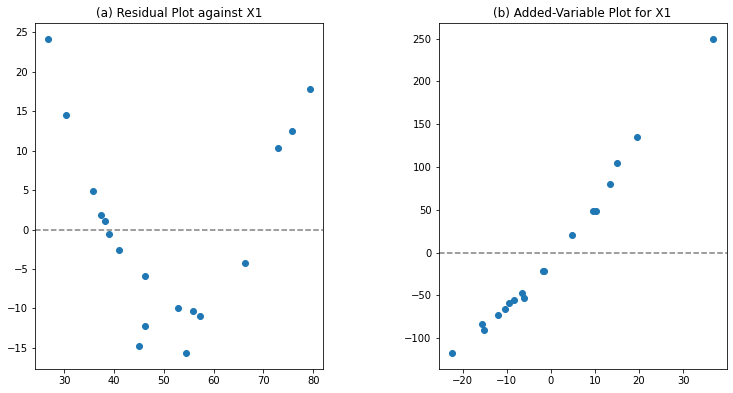

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(df.X1, model.resid)
axes[0].axhline(y=0, c="grey", ls="--")

axes[1].scatter(model1_2.resid, model2.resid)
axes[1].axhline(y=0, c="grey", ls="--")

axes[0].set_title("(a) Residual Plot against X1")
axes[1].set_title("(b) Added-Variable Plot for X1")
plt.show()

### Input the Body Fat Data

In [5]:
df = pd.read_pickle(f"{DATA_DIR}/CH07TA01.xz")
df.columns = ['X1', 'X2', 'X3', 'Y']
model = ols("Y ~ X1 + X2", df).fit()

### Figure 10.4 (p 389)

Residual Plots and Added-Variable Plots -- Body Fat Example with Two Predicator Variables

##### Note

Here we make use of the [partial regression plots](https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_partregress.html) (statsmodels) so as not to define 4 new models to reproduce these results.

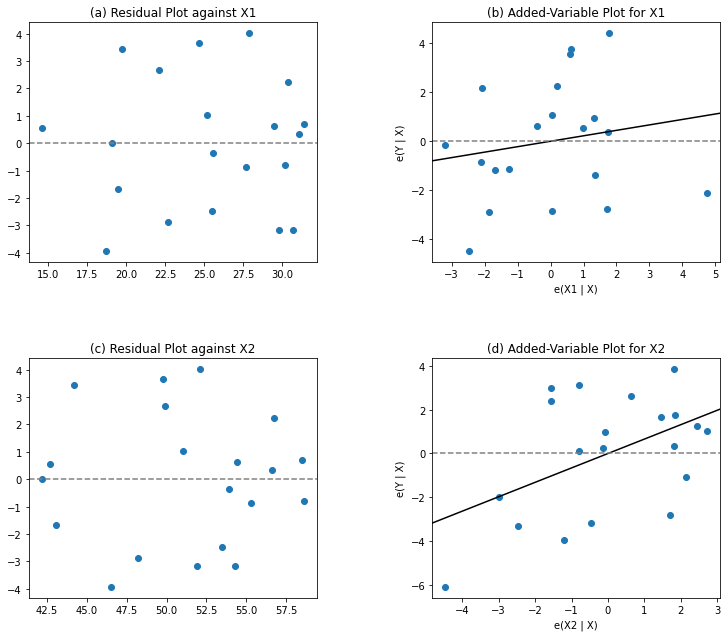

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0][0].scatter(df.X1, model.resid)
axes[0][0].axhline(y=0, c="grey", ls="--")

_ = sm.graphics.plot_partregress("Y", "X1", ["X2"], df, obs_labels=False, ax=axes[0][1])
axes[0][1].axhline(y=0, c="grey", ls="--")

axes[1][0].scatter(df.X2, model.resid)
axes[1][0].axhline(y=0, c="grey", ls="--")

_ = sm.graphics.plot_partregress("Y", "X2", ["X1"], df, obs_labels=False, ax=axes[1][1])
axes[1][1].axhline(y=0, c="grey", ls="--")

axes[0][0].set_title("(a) Residual Plot against X1")
axes[0][1].set_title("(b) Added-Variable Plot for X1")
axes[1][0].set_title("(c) Residual Plot against X2")
axes[1][1].set_title("(d) Added-Variable Plot for X2")
plt.show()

# 10.2 Identifying Outlying Y Observations -- Studentized Deleted Residuals (p 390)

In [7]:
df = pd.DataFrame({"X1": [14, 19, 12, 11], "X2": [25, 32, 22, 15], "Y": [301, 327, 246, 187]})
model = ols("Y ~ X1 + X2", df).fit()

### Table 10.2 (p 393)

Illustration of Hat Matrix

### (a) Data and Basic Results

In [8]:
model.HC1_se # needed for `het_scale` to be generated
pd.DataFrame({
    "X1": df.X1,
    "X2": df.X2,
    "Y": df.Y,
    yhat: model.fittedvalues,
    "e": model.resid,
    "h": model.get_influence().hat_matrix_diag,
    "s^2{e}": model.het_scale
})

,X1,X2,Y,ŷ,e,h,s^2{e}
0,14,25,301,282.237923,18.762077,0.387681,1408.062178
1,19,32,327,332.291868,-5.291868,0.951288,112.015466
2,12,22,246,259.951288,-13.951288,0.661433,778.553775
3,11,15,187,186.518921,0.481079,0.999597,0.925748


### (b) Hat Matrix

Here we compute the hat matrix by (10.10) defined as 

$H = X(X'X)^{-1}X'$

In [9]:
X = model.model.exog
H = X.dot(np.linalg.inv(X.transpose().dot(X))).dot(X.transpose())
H.round(4)

array([[ 0.3877,  0.1727,  0.4553, -0.0157],
       [ 0.1727,  0.9513, -0.1284,  0.0044],
       [ 0.4553, -0.1284,  0.6614,  0.0117],
       [-0.0157,  0.0044,  0.0117,  0.9996]])

### (c) Residual Variance-Covariance Matrix $S^2\{e\}$

In [10]:
np.set_printoptions(suppress=True)
S = model.mse_resid * (np.identity(len(H)) - H)
S.round(1)

array([[ 352. ,  -99.3, -261.8,    9. ],
       [ -99.3,   28. ,   73.8,   -2.5],
       [-261.8,   73.8,  194.6,   -6.7],
       [   9. ,   -2.5,   -6.7,    0.2]])

### Reload the Body Fat Data

In [11]:
df = pd.read_pickle(f"{DATA_DIR}/CH07TA01.xz")
df.columns = ['X1', 'X2', 'X3', 'Y']
model = ols("Y ~ X1 + X2", df).fit()

### Table 10.3 (p 397)

Residuals, Diagonal Elements of the Hat Matrix, and Studentized Deleted Residuals -- Body Fat Example with Two Predictor Variables

##### Note

The influence object ([statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html)) contains numerous useful metrics, including multiple studentized residuals. The external ones use the leave-one-observation-out (LOOO) variance, which is what we want for the deleted studentized residuals.

In [12]:
pd.DataFrame({
    "e": model.resid,
    "h": model.get_influence().hat_matrix_diag,
    "t": model.get_influence().resid_studentized_external
}).round(3)

,e,h,t
0,-1.683,0.201,-0.730
1,3.643,0.059,1.534
2,-3.176,0.372,-1.654
3,-3.158,0.111,-1.348
4,-0.000,0.248,-0.000
5,-0.361,0.129,-0.148
6,0.716,0.156,0.298
7,4.015,0.096,1.760
8,2.655,0.115,1.118
9,-2.475,0.110,-1.034


# 10.3 Identifying Outlying X Observations -- Hat Matrix Leverage Values (p 398)

## Figure 10.6 (p 398)

Illustration of Leverage Values as Distance Measures -- Table 10.2 Example

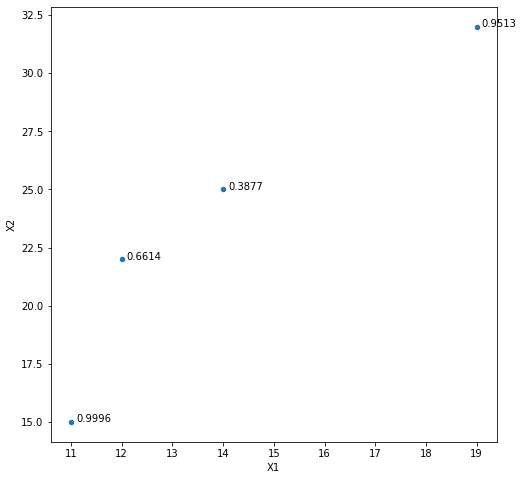

In [13]:
df10_2 = pd.DataFrame({"X1": [14, 19, 12, 11], "X2": [25, 32, 22, 15], "Y": [301, 327, 246, 187]})
model = ols("Y ~ X1 + X2", df10_2).fit()
H = np.array([str(round(h, 4)) for h in model.get_influence().hat_matrix_diag])
df10_2.plot.scatter("X1", "X2", figsize=(8,8))

for i, h in enumerate(H):
    plt.text(df10_2.X1[i]+0.1, df10_2.X2[i], h)

### Figure 10.7 (p 399)

Scatter Plot of Thigh Circumference against Triceps Skinfold Thickness -- Body Fat Example with Two Predicator Variables.

##### Note

While a bit more cluttered, it is easier than trying to refer back to Table 10.2 to identify each case number h value. Instead, I plot them against their case number. 

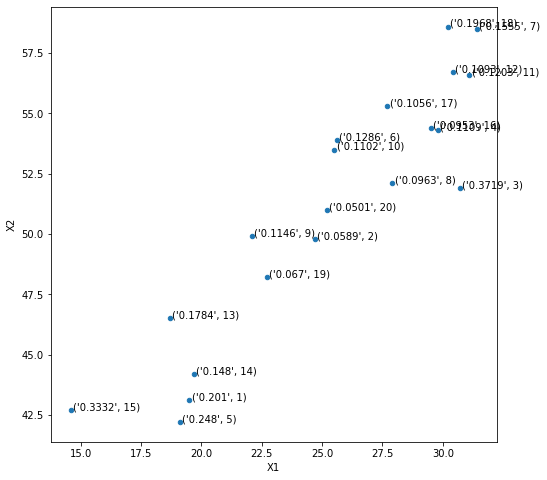

In [19]:
model = ols("Y ~ X1 + X2", df).fit()
H = np.array([str(round(h, 4)) for h in model.get_influence().hat_matrix_diag])
df.plot.scatter("X1", "X2", figsize=(8,8))

for i, h in enumerate(H):
    plt.text(df.X1[i]+0.1, df.X2[i], (h, i+1))

# 10.4 Identifying Influential Cases -- DFFITS, Cook's Distance, and DFBETAS Measures (p 400)

### Table 10.4 (p 401)

DFFITS, Cook's Distances, and DFBETAS -- Body Fat Example with Two Predictor Variables

##### Note

One of the easiest tables to model, this comes directly out of the model object's `get_influence` method, returned as a dataframe. For details, see the documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html)

In [34]:
influence = model.get_influence()
influence.summary_frame().round(3)

,dfb_Intercept,dfb_X1,dfb_X2,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.305,-0.131,0.232,0.046,-0.740,0.201,-0.371,-0.730,-0.366
1,0.173,0.115,-0.143,0.045,1.477,0.059,0.369,1.534,0.384
2,-0.847,-1.183,1.067,0.490,-1.576,0.372,-1.213,-1.654,-1.273
3,-0.102,-0.294,0.196,0.072,-1.317,0.111,-0.465,-1.348,-0.476
4,-0.000,-0.000,0.000,0.000,-0.000,0.248,-0.000,-0.000,-0.000
5,0.040,0.040,-0.044,0.001,-0.152,0.129,-0.058,-0.148,-0.057
6,-0.078,-0.016,0.054,0.006,0.306,0.156,0.132,0.298,0.128
7,0.261,0.391,-0.332,0.098,1.661,0.096,0.542,1.760,0.575
8,-0.151,-0.295,0.247,0.053,1.110,0.115,0.399,1.118,0.402
9,0.238,0.245,-0.269,0.044,-1.032,0.110,-0.363,-1.034,-0.364


### Figure 10.8 (p 404)

Proportional Influence Plot (Points Proportional in Size to Cook's Distnce Measure) and Index Influence Plot -- Body Fat Example with Two Predictor Variables.

##### Note

I use the built-in `influence_plot` that provides similar information. See documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.plot_influence.html)

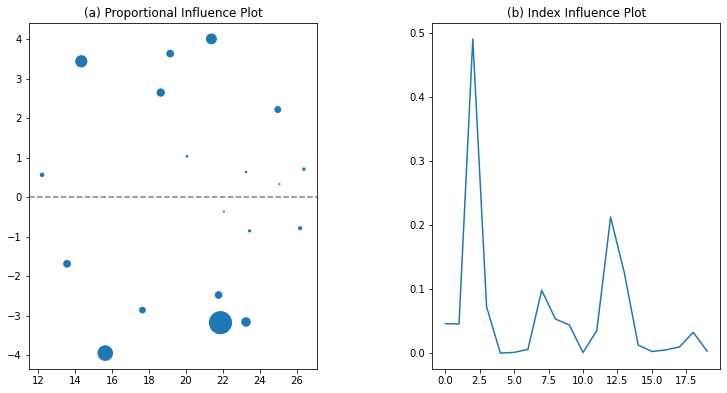

In [43]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(model.fittedvalues, model.resid, s=influence.cooks_distance[0]*1000)
axes[0].axhline(y=0, c="grey", ls="--")

axes[1].plot(range(0, len(df)), model.get_influence().cooks_distance[0])

axes[0].set_title("(a) Proportional Influence Plot")
axes[1].set_title("(b) Index Influence Plot")
plt.show()

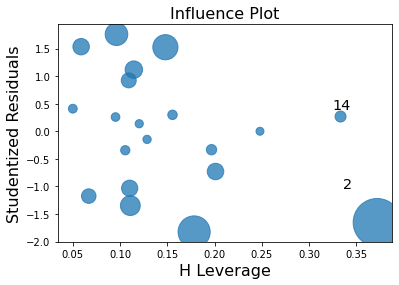

In [29]:
_ = sm.graphics.influence_plot(model)

# 10.5 Multicollinearity Diagnostics -- Variance Inflation Factor (p 406)

### Table 10.5 (p 409)

Variance Inflation Factors -- Body Fat Example with Three Predicator Variables

In [74]:
model = ols("Y ~ X1 + X2 + X3", df).fit()
vif = pd.DataFrame({
    "vif": [variance_inflation_factor(model.model.data.exog, i) for i in range(1, model.model.data.exog.shape[1])]
}, index=model.params.index[1:])
display(vif)
display(vif.mean())

,vif
X1,708.842914
X2,564.343386
X3,104.606005


vif    459.264102
dtype: float64

# 10.6 Surgical Unit Example -- Continued (p 410)

### Input the Surgical Unit Data

In [76]:
df = pd.read_pickle(f"{DATA_DIR}/CH09TA01.xz")
df.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y', 'lnY']
model = ols("lnY ~ X1 + X2 + X3 + X8", df).fit()

To examine interaction terms, added-variable plots are explained (p 410), but it is not clear how to assess those for indications of strong interactions in this instance. Instead, a partial F test is conducted by fitting the model with the additional interaction terms. The P-value of 0.35 indicating that interaction effects are not present.

In [137]:
anova_lm(model, ols("lnY ~ X1 + X2 + X3 + X8 + X1*X2 + X1*X3 + X1*X8 + X2*X3 + X2*X8 + X3*X8", df).fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,49.0,2.178799,0.0,NaN,NaN,NaN
1,43.0,1.875780,6.0,0.303018,1.157722,0.346488


### Figure 10.9 (p 411)

Residual and Added-Variable Plots for Surgical Unit Example -- Regression Model (10.45)

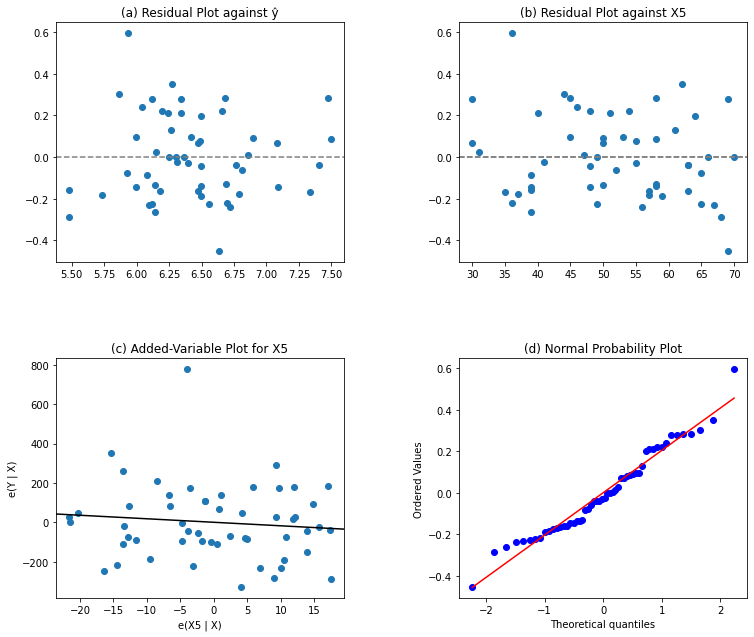

In [120]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0][0].scatter(model.fittedvalues, model.resid)
axes[0][0].axhline(y=0, c="grey", ls="--")

axes[0][1].scatter(df.X5, model.resid)
axes[0][1].axhline(y=0, c="grey", ls="--")

_ = sm.graphics.plot_partregress("Y", "X5", ["X1", "X2", "X3", "X8"], df, obs_labels=False, ax=axes[1][0])
axes[0][1].axhline(y=0, c="grey", ls="--")

qq = stats.probplot(model.resid, plot=axes[1][1])

axes[0][0].set_title(f"(a) Residual Plot against {yhat}")
axes[0][1].set_title("(b) Residual Plot against X5")
axes[1][0].set_title("(c) Added-Variable Plot for X5")
axes[1][1].set_title("(d) Normal Probability Plot")
plt.show()

Multicollinearity was also studied (p 412)

In [79]:
vif = pd.DataFrame({
    "vif": [variance_inflation_factor(model.model.data.exog, i) for i in range(1, model.model.data.exog.shape[1])]
}, index=model.params.index[1:])
display(vif)
display(vif.mean())

,vif
X1,1.102590
X2,1.019925
X3,1.048708
X8,1.091860


vif    1.065771
dtype: float64

### Figure 10.10 (p 413)

Diagnostic Plots for Surgical Unit Example -- Regression Model (10.45)

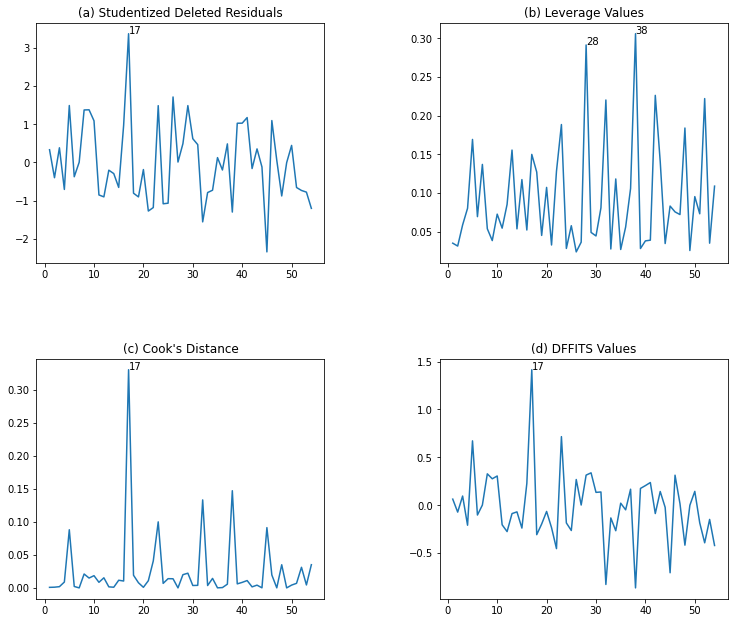

In [127]:
influence = model.get_influence().summary_frame()
x = range(1, len(df)+1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0][0].plot(x, influence.student_resid)
axes[0][0].text(17, influence.student_resid[17-1], 17)

axes[0][1].plot(x, influence.hat_diag)
axes[0][1].text(28, influence.hat_diag[28-1], 28)
axes[0][1].text(38, influence.hat_diag[38-1], 38)

axes[1][0].plot(x, influence.cooks_d)
axes[1][0].text(17, influence.cooks_d[17-1], 17)

axes[1][1].plot(x, influence.dffits)
axes[1][1].text(17, influence.dffits[17-1], 17)

axes[0][0].set_title("(a) Studentized Deleted Residuals")
axes[0][1].set_title("(b) Leverage Values")
axes[1][0].set_title("(c) Cook's Distance")
axes[1][1].set_title("(d) DFFITS Values")
plt.show()

### Table 10.6 (p 413)

Various Dignostics for Outlying Cases -- Surgical Unit Example, Regression Model (10.45)

##### Note

Since python is zero-indexed, the case numbers of interest are $(i-1)$ in code

In [117]:
cases = [16, 22, 27, 31, 37, 41, 51]
model.get_influence().summary_frame().loc[cases]

,dfb_Intercept,dfb_X1,dfb_X2,dfb_X3,dfb_X8,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
16,0.443734,-0.153797,0.626130,-1.140518,-0.010283,0.330619,3.061615,0.149919,1.285727,3.369599,1.415065
22,0.322193,0.048649,-0.465980,-0.148416,0.418894,0.100059,1.467492,0.188519,0.707317,1.485450,0.715972
27,-0.201114,0.241413,0.047507,0.073481,0.099894,0.020024,0.493451,0.291371,0.316416,0.489608,0.313951
31,-0.294476,-0.408486,0.324442,0.527579,0.167095,0.133329,-1.536299,0.220243,-0.816483,-1.558541,-0.828303
37,-0.224362,0.023964,0.699242,-0.416571,0.196143,0.147249,-1.292465,0.305914,-0.858048,-1.301587,-0.864104
41,-0.040245,0.039410,0.043536,-0.011868,-0.054288,0.001565,-0.163605,0.226227,-0.088463,-0.161971,-0.087580
51,-0.070680,0.070977,-0.171746,0.236438,-0.284998,0.031202,-0.739253,0.222076,-0.394981,-0.735785,-0.393128


As a direct measure of influence (p 412-413), we fit  model when case 17 is excluded from the model. We take the absolute percentage difference and also compare the average. The influence is negligable. 

In [119]:
exclude = df.index.isin([16])
model17 = ols(model.model.formula, df[~exclude]).fit()
influence = abs((model17.fittedvalues - model.fittedvalues[~exclude]) / model.fittedvalues[~exclude]) * 100
display(influence)
display(influence.mean())

0     0.059064
1     0.440662
2     0.090144
3     1.217622
4     0.615692
5     0.074255
6     0.256565
7     0.278953
8     0.101077
9     0.101602
10    0.348424
11    0.836610
12    0.108636
13    0.245970
14    0.309645
15    0.501643
17    1.072805
18    0.281176
19    0.111992
20    0.084397
21    1.209298
22    0.221377
23    0.059510
24    0.381500
25    0.267831
26    0.147224
27    0.107532
28    0.615181
29    0.826673
30    0.636950
31    1.197392
32    0.274057
33    0.028493
34    0.312725
35    0.451570
36    0.300204
37    1.600240
38    0.241964
39    0.200104
40    0.132720
41    0.753321
42    0.166196
43    0.067036
44    0.150611
45    0.349417
46    0.228542
47    0.038775
48    0.294883
49    0.012738
50    1.131637
51    1.320906
52    0.063641
53    0.402365
dtype: float64

0.4024443183812225